Darkcount data shape: (12, 640, 512)
Exposure times shape: (12,)
[1.000e-03 2.000e-03 4.000e-03 8.000e-03 1.600e-02 3.200e-02 6.400e-02
 1.280e-01 2.560e-01 5.120e-01 1.024e+00 2.048e+00]


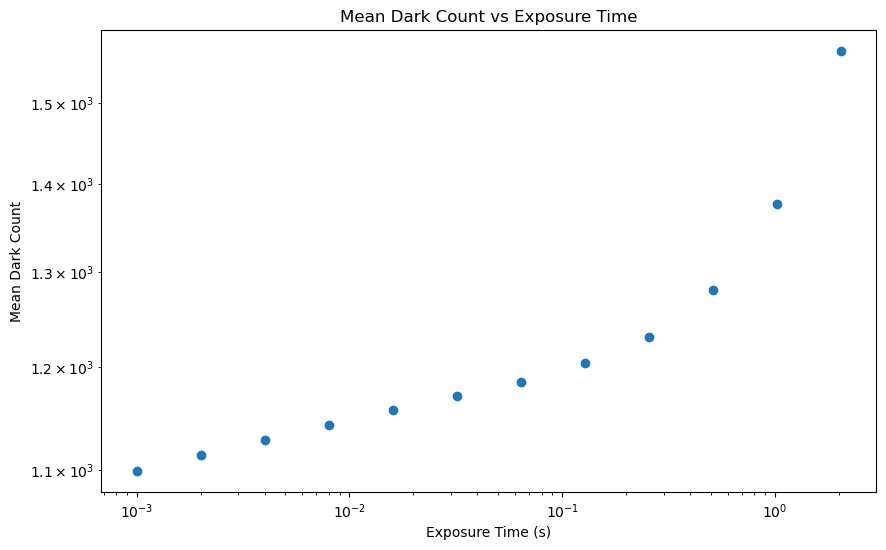

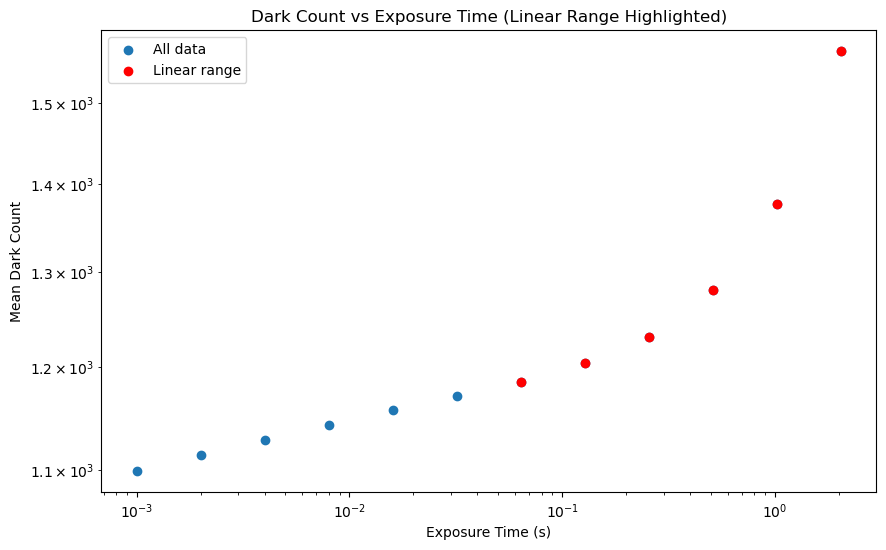

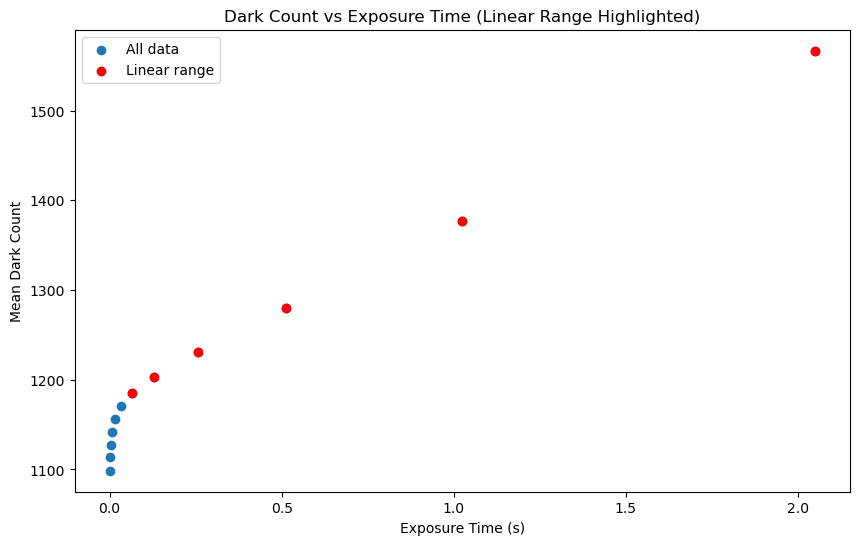

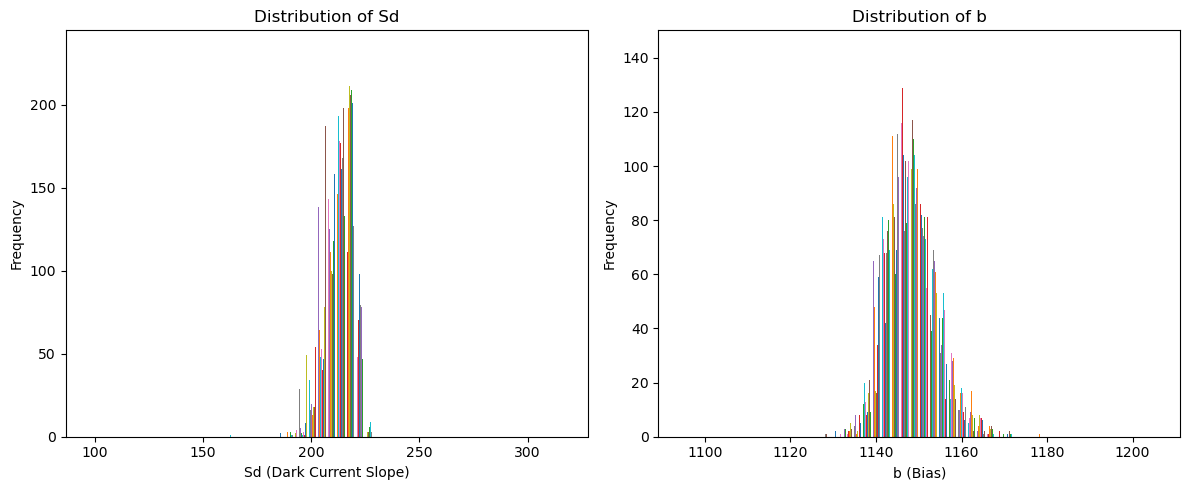

Linear range starts at exposure time: 0.064000 s
Mean Sd: 212.684977
Mean b: 1148.345742


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

def load_darkcount_data(data_directory):
    """Load darkcount data from NPY files."""
    darkcount_data = np.load(f'{data_directory}/darkcount_data.npy')
    exposure_times = np.load(f'{data_directory}/darkcount_exposure_times.npy')
    print(f"Darkcount data shape: {darkcount_data.shape}")
    print(f"Exposure times shape: {exposure_times.shape}")
    print(exposure_times)
    return darkcount_data, exposure_times

def model_dark_current(darkcount_data, exposure_times, data_directory):
    """Model dark current for each pixel and save Sd and b."""
    num_pixels = darkcount_data.shape[1] * darkcount_data.shape[2]
    darkcount_data_reshaped = darkcount_data.reshape(darkcount_data.shape[0], -1)
    
    Sd = np.zeros(num_pixels)
    b = np.zeros(num_pixels)
    
    for i in range(num_pixels):
        slope, intercept, _, _, _ = stats.linregress(exposure_times, darkcount_data_reshaped[:, i])
        Sd[i] = slope
        b[i] = intercept
    
    Sd = Sd.reshape(darkcount_data.shape[1], darkcount_data.shape[2])
    b = b.reshape(darkcount_data.shape[1], darkcount_data.shape[2])
    
    np.save(os.path.join(data_directory, 'Sd.npy'), Sd)
    np.save(os.path.join(data_directory, 'b.npy'), b)
    
    return Sd, b


def plot_mean_darkcount_vs_exposure(darkcount_data, exposure_times):
    """Plot mean darkcount vs exposure time."""
    mean_darkcounts = np.mean(darkcount_data, axis=(1, 2))
    
    if len(exposure_times) != len(mean_darkcounts):
        print("Warning: Exposure times and darkcount data have different lengths.")
        print(f"Exposure times length: {len(exposure_times)}")
        print(f"Mean darkcounts length: {len(mean_darkcounts)}")
        min_length = min(len(exposure_times), len(mean_darkcounts))
        exposure_times = exposure_times[:min_length]
        mean_darkcounts = mean_darkcounts[:min_length]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(exposure_times, mean_darkcounts)
    plt.xlabel('Exposure Time (s)')
    plt.ylabel('Mean Dark Count')
    plt.title('Mean Dark Count vs Exposure Time')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()


def find_linear_range(darkcount_data, exposure_times, r_squared_threshold=0.999):
    """Find the range where the relationship between counts and exposure time is linear."""
    mean_darkcounts = np.mean(darkcount_data, axis=(1, 2))
    
    if len(exposure_times) != len(mean_darkcounts):
        min_length = min(len(exposure_times), len(mean_darkcounts))
        exposure_times = exposure_times[:min_length]
        mean_darkcounts = mean_darkcounts[:min_length]

    linear_range_end = len(exposure_times)
    for i in range(2, len(exposure_times)):
        slope, intercept, r_value, _, _ = stats.linregress(exposure_times[-i:], mean_darkcounts[-i:])
        r_squared = r_value**2
        if r_squared < r_squared_threshold:
            linear_range_end = i - 1
            break
    
    return exposure_times[-linear_range_end:], mean_darkcounts[-linear_range_end:]

def plot_linear_range(exposure_times, mean_darkcounts, linear_exposure_times, linear_mean_darkcounts):
    """Plot the full range and the determined linear range."""
    plt.figure(figsize=(10, 6))
    plt.scatter(exposure_times, mean_darkcounts, label='All data')
    plt.scatter(linear_exposure_times, linear_mean_darkcounts, color='r', label='Linear range')
    plt.xlabel('Exposure Time (s)')
    plt.ylabel('Mean Dark Count')
    plt.title('Dark Count vs Exposure Time (Linear Range Highlighted)')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()


    plt.figure(figsize=(10, 6))
    plt.scatter(exposure_times, mean_darkcounts, label='All data')
    plt.scatter(linear_exposure_times, linear_mean_darkcounts, color='r', label='Linear range')
    plt.xlabel('Exposure Time (s)')
    plt.ylabel('Mean Dark Count')
    plt.title('Dark Count vs Exposure Time (Linear Range Highlighted)')
    plt.xscale('linear')
    plt.yscale('linear')
    plt.legend()
    plt.show()


def plot_model_parameters(Sd, b):
    """Plot histograms of the model parameters."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.hist(Sd, bins=50)
    ax1.set_xlabel('Sd (Dark Current Slope)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Sd')
    
    ax2.hist(b, bins=50)
    ax2.set_xlabel('b (Bias)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of b')
    
    plt.tight_layout()
    plt.show()

def main(data_directory):
    # Load data
    darkcount_data, exposure_times = load_darkcount_data(data_directory)
    
    # Ensure darkcount_data and exposure_times have matching lengths
    min_length = min(len(exposure_times), darkcount_data.shape[0])
    darkcount_data = darkcount_data[:min_length]
    exposure_times = exposure_times[:min_length]

    # Plot mean darkcount vs exposure time
    plot_mean_darkcount_vs_exposure(darkcount_data, exposure_times)
    
    # Find linear range
    linear_exposure_times, linear_mean_darkcounts = find_linear_range(darkcount_data, exposure_times)
    
    # Plot linear range
    plot_linear_range(exposure_times, np.mean(darkcount_data, axis=(1, 2)), 
                      linear_exposure_times, linear_mean_darkcounts)
    
    # Model dark current and save Sd and b
    Sd, b = model_dark_current(darkcount_data, exposure_times, data_directory)
    
    # Plot model parameters
    plot_model_parameters(Sd, b)
    
    print(f"Linear range starts at exposure time: {linear_exposure_times[0]:.6f} s")
    print(f"Mean Sd: {np.mean(Sd):.6f}")
    print(f"Mean b: {np.mean(b):.6f}")

# Usage
experiment_title = 'Water_immersed'
data_directory = f'data/{experiment_title}'
main(data_directory)